In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


## Web Scrapping

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm

# Function to convert base URL to review page URL
def convert_to_review_url(base_url):
    # Split the base URL to get the parts before and after the product identifier
    parts = base_url.split('/p/')
    
    # Ensure the URL is in the expected format
    if len(parts) != 2:
        raise ValueError("URL format is not as expected.")
    
    # Construct the review page URL
    review_page_url = parts[0] + '/product-reviews/' + parts[1]
    
    # Remove any parameters after the product ID and keep only the necessary ones
    review_page_url = review_page_url.split('?')[0] + '?' + '&'.join([param for param in base_url.split('?')[1].split('&') if param.startswith('pid=') or param.startswith('lid=') or param.startswith('marketplace=')])
    
    return review_page_url

# User-Agent and Accept-Language headers
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36',
    'Accept-Language': 'en-us,en;q=0.5'
}

customer_names = []
review_title = []
ratings = []
comments = []

# Input base URL and convert it to review page URL
base_url = input("Enter the product URL: ")
review_url = convert_to_review_url(base_url)

for i in tqdm(range(1, 500)):
    # Construct the URL for the current page
    current_url = f"{review_url}&page={i}"
    
    # Send a GET request to the page
    page = requests.get(current_url, headers=headers)

    # Parse the HTML content
    soup = BeautifulSoup(page.content, 'html.parser')

    # Extract customer names
    names = soup.find_all('p', class_='_2NsDsF AwS1CA')
    for name in names:
        customer_names.append(name.get_text())

    # Extract review titles
    title = soup.find_all('p', class_='z9E0IG')
    for t in title:
        review_title.append(t.get_text())

    # Extract ratings
    rat = soup.find_all('div', class_='XQDdHH Ga3i8K')
    for r in rat:
        rating = r.get_text()
        if rating:
            ratings.append(rating)
        else:
            ratings.append('0')  # Replace null ratings with 0

    # Extract comments
    cmt = soup.find_all('div', class_='ZmyHeo')
    for c in cmt:
        comment_text = c.div.div.get_text(strip=True)
        comments.append(comment_text)

# Ensure all lists have the same length
min_length = min(len(customer_names), len(review_title), len(ratings), len(comments))
customer_names = customer_names[:min_length]
review_title = review_title[:min_length]
ratings = ratings[:min_length]
comments = comments[:min_length]

# Create a DataFrame from the collected data
data = {
    'Customer Name': customer_names,
    'Review Title': review_title,
    'Rating': ratings,
    'Comment': comments
}

df = pd.DataFrame(data)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Save the DataFrame to a CSV file
df.to_csv('product_reviews.csv', index=False)



Enter the product URL: https://www.flipkart.com/urban-terrain-bolt-cycles-men-front-suspension-dual-disc-brake-mtb-bike-ut5000s27-5-27-5-t-road-cycle/p/itm25156e6229e34?pid=CCEG6GEEGMUCJGJM&lid=LSTCCEG6GEEGMUCJGJMUMCO26&marketplace=FLIPKART&store=abc%2Fulv%2Fixt&srno=b_1_1&otracker=browse&fm=organic&iid=en_RsNcAcgk44uRX5UIkhiupkx0KVTqkmvgttlQc1gEfLPQLU7naso6Pfw_sMyhRSmXmhi2OgGMeSFH4KCL2tUCqg%3D%3D&ppt=browse&ppn=browse&ssid=8scwrkvbcj8o51q81717186046004


  0%|          | 0/499 [00:00<?, ?it/s]

## Data Cleaning

In [3]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Read the CSV file
df = pd.read_csv('product_reviews.csv')

# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r"(http\S+|www\S+)", "", text)
    # Remove special characters
    text = re.sub(r"[^\w\s]", "", text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

# Apply text cleaning function
df['clean_text'] = df['Comment'].apply(clean_text)

# Download NLTK resources if not downloaded already
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Tokenization, removing stopwords, and lemmatization
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = tokenizer.tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing function to 'clean_text' column
df['Cleaned_text'] = df['clean_text'].apply(preprocess_text)

# Save the processed DataFrame to the same CSV file
selected_columns = ['Customer Name', 'Review Title', 'Rating', 'Comment', 'Cleaned_text']
cleaned_df = df[selected_columns]
cleaned_df.to_csv('product_reviews.csv', index=False) #here we are stroing the cleaned csv file


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sudipa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sudipa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sudipa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Sentiment Analysis using VADER

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sudipa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Performing Sentiment Analysis on Product Reviews:
Enter specific keywords to search for (comma-separated): look
Enter the number of reviews you want to analyze: 100

Corresponding Comments:
1. I really nice experience on fitplus app. My dietitian Pooja tumma is very helpful and knowledgeable .she made my nutrition and diet plan very well. I am followingevery thing told by the dietitian and feeling change kr in my fitness level and the cycle is very good looking ,working very smoothly.
2. Cycle is very good looking.and nice suspension the tires are well appreciable  service don't worry is u face any problem.The customer care will solve everything.
3. Value for money. Good looks. Good performance overall.
4. Satisfied with the design, look and sturdiness of the product. Purchased mud guard separately. Product delivered on time and installation on the third day of receiving. Got follow up calls which was nice. Friendly customer service personnel. Overall satisfied with Urban Terrain team 

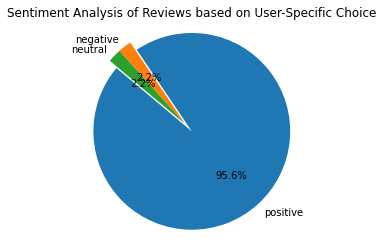


Sentiment Analysis Summary using VADER:
Positive: 95.56%
Negative: 2.22%
Neutral: 2.22%


In [4]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import csv
import nltk
nltk.download('vader_lexicon')

def analyze_sentiment(comment):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(comment)
    return sentiment_scores

def search_comments(csv_file, criteria, num_reviews):
    relevant_comments = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            comment = row['Cleaned_text'].lower()
            if any(word in comment for word in criteria):
                relevant_comments.append(row['Comment'])
                if len(relevant_comments) == num_reviews:
                    break  # Stop after reaching the specified number of reviews
    return relevant_comments

if __name__ == "__main__":
    csv_file = 'product_reviews.csv'
    print("Performing Sentiment Analysis on Product Reviews:")

    user_criteria = input("Enter specific keywords to search for (comma-separated): ").lower()
    criteria_list = [c.strip() for c in user_criteria.split(',')]

    num_reviews = int(input("Enter the number of reviews you want to analyze: "))

    relevant_comments = search_comments(csv_file, criteria_list, num_reviews)

    if not relevant_comments:
        print(f"\nNo reviews found regarding '{', '.join(criteria_list)}' in the 'product_reviews.csv'.")
    else:
        print("\nCorresponding Comments:")
        for index, comment in enumerate(relevant_comments, start=1):
            print(f"{index}. {comment}")

        # Perform sentiment analysis on the relevant comments
        sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}
        for comment in relevant_comments:
            sentiment_scores = analyze_sentiment(comment)
            if sentiment_scores['compound'] >= 0.05:
                sentiments['positive'] += 1
            elif sentiment_scores['compound'] <= -0.05:
                sentiments['negative'] += 1
            else:
                sentiments['neutral'] += 1

        # Display sentiment percentages in a pie chart
        labels = sentiments.keys()
        sizes = sentiments.values()
        explode = (0.1, 0, 0)  # Explode the 1st slice (positive sentiment)

        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title('Sentiment Analysis of Reviews based on User-Specific Choice')
        plt.show()

        # Display sentiment percentages in text
        total_reviews = sum(sentiments.values())
        print("\nSentiment Analysis Summary using VADER:")
        for sentiment, count in sentiments.items():
            percentage = (count / total_reviews) * 100
            print(f"{sentiment.capitalize()}: {percentage:.2f}%")

## Sentiment Analysis using TextBlob

Performing Sentiment Analysis on Product Reviews:
Enter specific keywords to search for (comma-separated): look
Enter the number of reviews you want to analyze: 100

Corresponding Comments:
1. I really nice experience on fitplus app. My dietitian Pooja tumma is very helpful and knowledgeable .she made my nutrition and diet plan very well. I am followingevery thing told by the dietitian and feeling change kr in my fitness level and the cycle is very good looking ,working very smoothly.
2. Cycle is very good looking.and nice suspension the tires are well appreciable  service don't worry is u face any problem.The customer care will solve everything.
3. Value for money. Good looks. Good performance overall.
4. Satisfied with the design, look and sturdiness of the product. Purchased mud guard separately. Product delivered on time and installation on the third day of receiving. Got follow up calls which was nice. Friendly customer service personnel. Overall satisfied with Urban Terrain team 

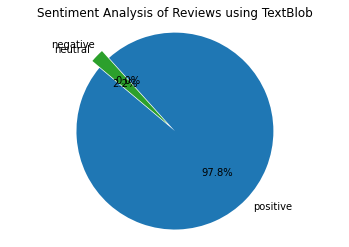


TextBlob Sentiment Analysis Summary:
Positive: 97.78%
Negative: 0.00%
Neutral: 2.22%


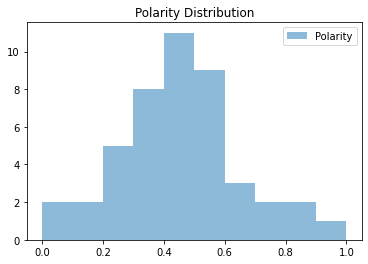

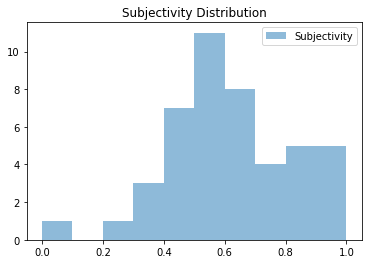


Overall Polarity: 0.46 (positive)
Overall Subjectivity: 0.62 (highly subjective)
Overall sentiment evaluation: fair


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob

def analyze_sentiment_textblob(comment):
    analysis = TextBlob(comment)
    polarity = analysis.sentiment.polarity
    subjectivity = analysis.sentiment.subjectivity
    return polarity, subjectivity

def search_comments(csv_file, criteria, num_reviews):
    relevant_comments = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            comment = row['Cleaned_text'].lower()
            if any(word in comment for word in criteria):
                relevant_comments.append(row['Comment'])
                if len(relevant_comments) == num_reviews:
                    break
    return relevant_comments

def evaluate_fairness(polarity, subjectivity):
    if polarity > 0:
        polarity_desc = "positive"
    elif polarity < 0:
        polarity_desc = "negative"
    else:
        polarity_desc = "neutral"

    if subjectivity > 0.5:
        subjectivity_desc = "highly subjective"
    elif subjectivity < 0.5:
        subjectivity_desc = "objective"
    else:
        subjectivity_desc = "neutral"

    if polarity == 0 and subjectivity == 0:
        fairness_desc = "not the finest answer we’d expect"
    else:
        fairness_desc = "fair"

    return polarity_desc, subjectivity_desc, fairness_desc

if __name__ == "__main__":
    csv_file = 'product_reviews.csv'
    print("Performing Sentiment Analysis on Product Reviews:")

    user_criteria = input("Enter specific keywords to search for (comma-separated): ").lower()
    criteria_list = [c.strip() for c in user_criteria.split(',')]

    num_reviews = int(input("Enter the number of reviews you want to analyze: "))

    relevant_comments = search_comments(csv_file, criteria_list, num_reviews)

    if not relevant_comments:
        print(f"\nNo reviews found regarding '{', '.join(criteria_list)}' in 'product_reviews.csv'.")
    else:
        print("\nCorresponding Comments:")
        for index, comment in enumerate(relevant_comments, start=1):
            print(f"{index}. {comment}")

        # Perform sentiment analysis using TextBlob
        sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}
        polarities = []
        subjectivities = []

        for comment in relevant_comments:
            polarity, subjectivity = analyze_sentiment_textblob(comment)
            polarities.append(polarity)
            subjectivities.append(subjectivity)
            
            if polarity > 0:
                sentiments['positive'] += 1
            elif polarity < 0:
                sentiments['negative'] += 1
            else:
                sentiments['neutral'] += 1

        # Calculate overall polarity and subjectivity
        overall_polarity = sum(polarities) / len(polarities)
        overall_subjectivity = sum(subjectivities) / len(subjectivities)

        # Evaluate overall fairness
        polarity_desc, subjectivity_desc, fairness_desc = evaluate_fairness(overall_polarity, overall_subjectivity)

        # Display sentiment percentages in a pie chart
        labels = sentiments.keys()
        sizes = sentiments.values()
        explode = (0.1, 0, 0)  # Explode the 1st slice (positive sentiment)
        plt.figure()
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title('Sentiment Analysis of Reviews using TextBlob')
        plt.show()

        # Display sentiment percentages in text
        total_reviews = sum(sentiments.values())
        print("\nTextBlob Sentiment Analysis Summary:")
        for sentiment, count in sentiments.items():
            percentage = (count / total_reviews) * 100
            print(f"{sentiment.capitalize()}: {percentage:.2f}%")

        # Display polarity and subjectivity distributions
        plt.figure()
        plt.hist(polarities, bins=10, alpha=0.5, label='Polarity')
        plt.legend(loc='upper right')
        plt.title('Polarity Distribution')
        plt.show()

        plt.figure()
        plt.hist(subjectivities, bins=10, alpha=0.5, label='Subjectivity')
        plt.legend(loc='upper right')
        plt.title('Subjectivity Distribution')
        plt.show()

        # Display overall polarity and subjectivity with evaluation
        print(f"\nOverall Polarity: {overall_polarity:.2f} ({polarity_desc})")
        print(f"Overall Subjectivity: {overall_subjectivity:.2f} ({subjectivity_desc})")
        print(f"Overall sentiment evaluation: {fairness_desc}")


In [6]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the data
data_file_path = 'product_reviews.csv'  # Adjust the file path as needed
data = pd.read_csv(data_file_path)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(comment):
    """Determine sentiment using VADER."""
    scores = analyzer.polarity_scores(comment)
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the 'Comment' column
data['True Sentiment'] = data['Comment'].apply(get_sentiment)

# Save the relevant columns to a new CSV file
new_file_path = 'product_reviews_with_sentiment.csv'
data[['Comment', 'True Sentiment']].to_csv(new_file_path, index=False)

print(f"Sentiment analysis completed and saved to {new_file_path}")


Sentiment analysis completed and saved to product_reviews_with_sentiment.csv


## Comparison VADER with TextBlob

In [7]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

# Load the spaCy English model (for tokenization, not sentiment)
nlp = spacy.load("en_core_web_sm")

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_textblob(comment):
    analysis = TextBlob(comment)
    return 'positive' if analysis.sentiment.polarity > 0 else 'negative' if analysis.sentiment.polarity < 0 else 'neutral'

def analyze_sentiment_vader(comment):
    scores = analyzer.polarity_scores(comment)
    return 'positive' if scores['compound'] > 0.05 else 'negative' if scores['compound'] < -0.05 else 'neutral'

def load_data_and_predict_sentiments(csv_file):
    data = pd.read_csv(csv_file)
    data['predicted_textblob'] = data['Comment'].apply(analyze_sentiment_textblob)
    data['predicted_vader'] = data['Comment'].apply(analyze_sentiment_vader)
    return data

def calculate_accuracy(data):
    accuracy_textblob = accuracy_score(data['True Sentiment'], data['predicted_textblob'])
    accuracy_vader = accuracy_score(data['True Sentiment'], data['predicted_vader'])
    return accuracy_textblob, accuracy_vader

def main():
    csv_file = 'product_reviews_with_sentiment.csv'
    data = load_data_and_predict_sentiments(csv_file)
    accuracy_textblob, accuracy_vader = calculate_accuracy(data)

    print(f"Accuracy with TextBlob: {accuracy_textblob:.2%}")
    print(f"Accuracy with VADER: {accuracy_vader:.2%}")

    # Determine which model is superior
    if accuracy_textblob > accuracy_vader:
        print("TextBlob performs better.")
    elif accuracy_vader > accuracy_textblob:
        print("VADER performs better.")
    else:
        print("Both models perform equally.")

if __name__ == "__main__":
    main()


Accuracy with TextBlob: 92.67%
Accuracy with VADER: 100.00%
VADER performs better.


# Deployment phase

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import csv
import nltk
nltk.download('vader_lexicon')

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

def analyze_sentiment(comment):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(comment)
    return sentiment_scores

def search_comments(csv_file, criteria, num_reviews):
    relevant_comments = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            comment = row['Cleaned_text'].lower()
            if any(word in comment for word in criteria):
                relevant_comments.append(row['Comment'])
                if len(relevant_comments) == num_reviews:
                    break  # Stop after reaching the specified number of reviews
    return relevant_comments

@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        return review_analysis()
    return render_template("index.html")

@app.route("/review_analysis", methods=["GET", "POST"])
def review_analysis():
    if request.method == "POST":
        csv_file = 'product_reviews.csv'
        user_criteria = request.form.get("criteria").lower()
        criteria_list = [c.strip() for c in user_criteria.split(',')]
        num_reviews = int(request.form.get("num_reviews"))

        relevant_comments = search_comments(csv_file, criteria_list, num_reviews)

        if not relevant_comments:
            return render_template("index.html", message=f"No reviews found regarding '{', '.join(criteria_list)}' in the 'product_reviews.csv'.")
        else:
            sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}
            for comment in relevant_comments:
                sentiment_scores = analyze_sentiment(comment)
                if sentiment_scores['compound'] >= 0.05:
                    sentiments['positive'] += 1
                elif sentiment_scores['compound'] <= -0.05:
                    sentiments['negative'] += 1
                else:
                    sentiments['neutral'] += 1

            total_reviews = sum(sentiments.values())
            sentiment_percentages = {sentiment.capitalize(): (count / total_reviews) * 100 for sentiment, count in sentiments.items()}

            labels = sentiment_percentages.keys()
            sizes = sentiment_percentages.values()
            explode = (0.1, 0, 0)  # Explode the 1st slice (positive sentiment)

            plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
            plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            plt.title('Sentiment Analysis of Reviews based on User-Specific Choice')
            plt.savefig('static/sentiment_pie_chart.png')  # Save the pie chart as an image

            return render_template("review_analysis.html", analysis=sentiment_percentages, comments=relevant_comments)

    return render_template("review_analysis.html")

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sudipa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
Exception in thread Thread-9:
Traceback (most recent call last):
  File "c:\users\sudipa\appdata\local\programs\python\python36\lib\site-packages\urllib3\connection.py", line 175, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "c:\users\sudipa\appdata\local\programs\python\python36\lib\site-packages\urllib3\util\connection.py", line 95, in create_connection
    raise err
  File "c:\users\sudipa\appdata\local\programs\python\python36\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most rec